
# <center>Car Recognize Bot</center>

In [ ]:
!pip install pytorch_lightning

In [ ]:
!pip install mlflow

In [36]:
import os 
import glob
import PIL
import random
import cv2
import torch
import pandas as pd
import numpy as np
import pytorch_lightning as pl

import torch.nn as nn
from torchvision.models import resnet50
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.optim import SGD
from pytorch_lightning.loggers import MLFlowLogger
from torch.optim.lr_scheduler import ReduceLROnPlateau

import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline

## Connect to Google Drive

In [4]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


## Data Inspect

In [5]:
TRAIN_DIR = "/content/drive/MyDrive/Car-Recognize-Bot/car_data/train"
TEST_DIR = "/content/drive/MyDrive/Car-Recognize-Bot/car_data/test"
VALID_DIR = "/content/drive/MyDrive/Car-Recognize-Bot/car_data/valid"

In [6]:
train_car_dirs = sorted(
    glob.glob(os.path.join(TRAIN_DIR, "*"))
)
test_car_dirs = sorted(
    glob.glob(os.path.join(TEST_DIR, "*"))
)
valid_car_dirs = sorted(
    glob.glob(os.path.join(VALID_DIR, "*"))
)

In [7]:
all_train_images = 0

for car_dir in train_car_dirs:
    all_train_images += len(os.listdir(car_dir))

In [8]:
all_test_images = 0

for car_dir in test_car_dirs:
    all_test_images += len(os.listdir(car_dir))

In [9]:
all_valid_images = 0

for car_dir in valid_car_dirs:
    all_valid_images += len(os.listdir(car_dir))

In [10]:
print("All images for training: ", all_train_images) 
print("All images for validation: ", all_valid_images)
print("All images for test: ", all_test_images)

All images for training:  8091
All images for validation:  3977
All images for test:  4064


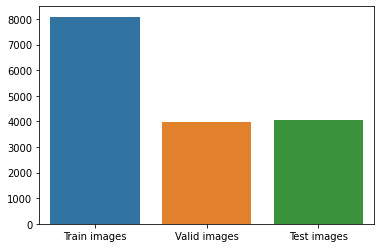

In [11]:
sns.barplot(x=['Train images', 'Valid images', 'Test images'], 
            y=[all_train_images, all_valid_images, all_test_images ])

## Pictures View

In [12]:
def match_label(labels):

    names = pd.read_csv("/content/drive/MyDrive/Car-Recognize-Bot/car_data/names.csv", header=None, names=['name']).reset_index()

    indexes = [names[names['name'] == label]['index'].to_numpy() for label in labels]

    return indexes

In [13]:
def images_and_labels(dir_path):
    car_dirs = sorted([os.path.join(dir_path, car_dir) for car_dir in os.listdir(dir_path)])

    images = []

    for car_dir in car_dirs:
        for image in os.listdir(car_dir):
            images.append(os.path.join(car_dir, image))

    values = [os.path.basename(os.path.dirname(item)) for item in images]

    labels = match_label(values)

    return images, labels

In [14]:
train_images, train_labels = images_and_labels(TRAIN_DIR)
valid_images, valid_labels = images_and_labels(VALID_DIR)
test_images, test_labels = images_and_labels(TEST_DIR)

In [15]:
names = pd.read_csv("/content/drive/MyDrive/Car-Recognize-Bot/car_data/names.csv", header=None, names=['name']).reset_index()

In [16]:
names.head()

,index,name
0,0,AM General Hummer SUV 2000
1,1,Acura RL Sedan 2012
2,2,Acura TL Sedan 2012
3,3,Acura TL Type-S 2008
4,4,Acura TSX Sedan 2012


In [17]:
def draw_image_with_label(images, labels):
  index = random.randint(0, len(images))

  title = names.iloc[train_labels[index][0]]['name']
  plt.title(title)

  image = cv2.imread(train_images[index])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  plt.imshow(image)

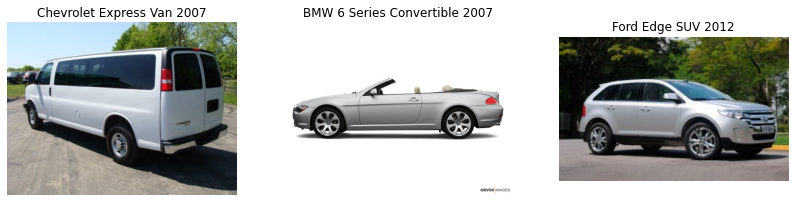

In [18]:
plt.figure(figsize=(14,8))

for i in range(1, 4):
  plt.subplot(1, 3, i)

  draw_image_with_label(train_images, train_labels)

  plt.axis('off');

## Dataloaders

In [20]:
def dataloader(dir_path: str, transforms, shuffle: bool = True):
    dataset = ImageFolder(root=dir_path, transform=transforms)

    return DataLoader(dataset, batch_size=32, shuffle=shuffle, num_workers=os.cpu_count())

## Transformers


In [21]:
train_transforms = transforms.Compose(
        [
            transforms.Resize((400, 400)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

test_transforms = transforms.Compose(
    [
        transforms.Resize((400, 400)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [ ]:
train_loader = dataloader(TRAIN_DIR, transforms=train_transforms)
valid_loader = dataloader(VALID_DIR, transforms=train_transforms)
test_loader = dataloader(TEST_DIR, transforms=test_transforms, shuffle=False)

## Model

In [22]:
class CarNet(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = resnet50(pretrained=True)
        self.num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(self.num_ftrs, 196)

        self.loss_function = nn.CrossEntropyLoss()
        self.losses = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        output = self.forward(images)

        self.loss = self.loss_function(output, labels)
        self.losses.append(self.loss)

        return {"loss": self.loss}

    def validation_step(self, batch, batch_idx):
        pass

    def validation_epoch_end(self, validation_step_outputs):
        pass

    def test_step(self, batch, batch_idx):
        pass

    def get_callback_metrics(self) -> dict: 
        result = { 
            'loss': self.loss, 
        }
      
        return result 

    def configure_optimizers(self):
        optimizer = SGD(self.model.parameters(), lr=0.01, momentum=0.9)
        lrscheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
        return {"optimizer": optimizer, "lr_scheduler": lrscheduler, "monitor": "loss"}


## Model Train

In [ ]:
# Model.
car_net = CarNet()

# Logger.
mlf_logger = MLFlowLogger(experiment_name="car-recognize", tracking_uri="file:./ml-runs")

# Trainer.
trainer = pl.Trainer(
    gpus=[0],
    max_epochs=10,
    logger=mlf_logger,
    enable_checkpointing=True,
    num_sanity_val_steps=1,
    log_every_n_steps=16,
)

# Model train.
trainer.fit(
    model=car_net,
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader,
)

# Model test.
trainer.test(dataloaders=test_loader)

## Model Results

In [ ]:
!pip install onnxruntime

In [25]:
import onnxruntime

In [37]:
loader = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
image = Image.open(train_images[0])
image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)
image = image.unsqueeze(0)

In [27]:
def read_image(image: str):
    """
    Read image and prepare it.
    Args:
        image: path to image.

    Returns: numpy array.
    """
    image = Image.open(image)
    train_transforms = transforms.Compose(
        [
            transforms.Resize((400, 400)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    return train_transforms(image).unsqueeze(0).numpy()


In [28]:
session = onnxruntime.InferenceSession("/content/drive/MyDrive/Car-Recognize-Bot/model.onnx")

In [53]:
index = random.randint(0, len(test_images))

In [54]:
image = read_image(test_images[index])

In [55]:
result = session.run(None, {'input': image})[0]

In [56]:
conf, predicted = torch.max(torch.from_numpy(result), 1)

In [63]:
ind = np.argpartition(result[0], -3)[-3:]
ind

array([ 45, 178, 179])

In [64]:
result[0][ind]

array([6.0620747, 9.431622 , 9.5414095], dtype=float32)

Spyker C8 Coupe 2009 confidence:  9.541409492492676
Spyker C8 Convertible 2009


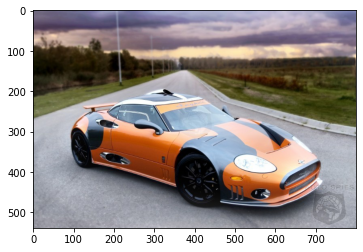

In [62]:
plt.imshow(Image.open(test_images[index]))
print(names.iloc[predicted.item()]['name'], "confidence: ", conf.item())
print(names.iloc[test_labels[index][0]]['name'])

In [ ]:
|